In [1]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser

from wlenet import config
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import get_output_dim, load_model, load_spec, save_model, save_spec, print_spec
from wlenet.dataset.io import load_sim, load_target
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.figures import show_stamps
from wlenet.models.figures import show_scatter_label_pred, show_first_conv_kernels
from wlenet.models.predict import predict, predict_test_time_aug

/cs/phd/springer/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
save_model_spec = True
save_model_weights = True

{'arch_name': 'cnn_image',
 'calib': {'ptta': (-0.00020902081232403532, -0.7374628839721707, 5.468994503277263e-05, -0.7311812665278514)},
 'kwargs_arch': {'dropout_dense_rate': 0.3, 'out_dim': 2, 'use_discriminator': False, 'use_dropout_dense': True},
 'kwargs_dataset': {'noise_kernel_factor': 0.25,
                    'noise_kernel_name': 'clash',
                    'post_sim': {'flux_cut_min': -inf, 'flux_factor': 0.32, 'intensity_cutoff': 0.012},
                    'sim_names_test': ['low_002', 'med_002', 'hig_002', 'low_004', 'med_004', 'hig_004'],
                    'sim_names_train': ['low_002', 'med_002', 'hig_002', 'low_004', 'med_004', 'hig_004'],
                    'target_header_path': None},
 'kwargs_train': {'epochs': 100, 'label_loss': 'mean_squared_error', 'patience': 10},
 'trained_name': 'cnn_image_clash_uniform_mse_noise_0.250'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu

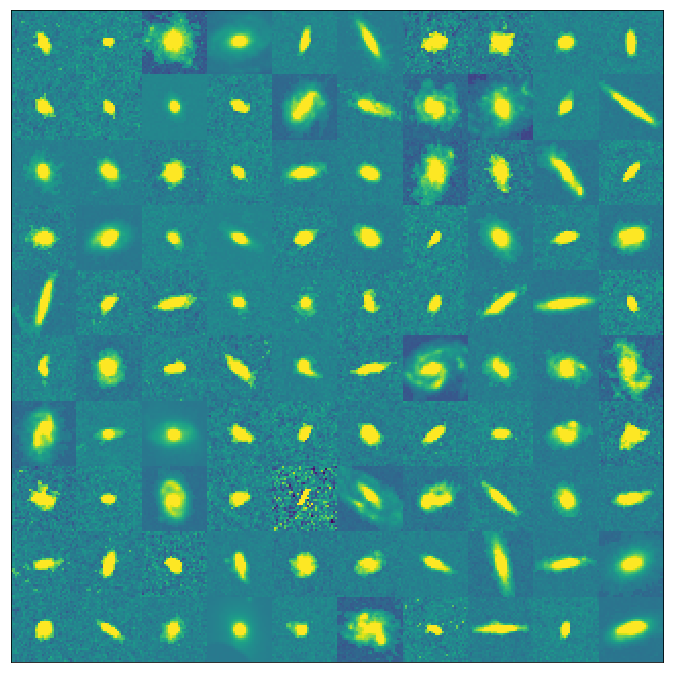

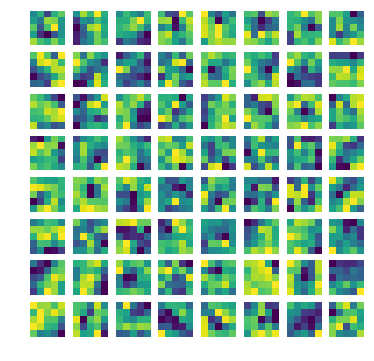

0.010377529892629628


In [3]:
model_spec = load_spec('cnn_image_clash_uniform_mse_noise_0.250')
print_spec(model_spec)
model = load_model(model_spec, load_weights=True, show_summary=True)

model_spec['kwargs_dataset']['sim_names_train'] = ['clash_004_train']
model_spec['kwargs_dataset']['noise_kernel_factor'] = 0.250
model_spec['trained_name'] = 'cnn_image_clash_uniform_mse_lsq_noise_0.250'
model_spec['calib'] = (0, 0, 0, 0)

print_spec(model_spec)

noise_kernel_path = config['calibration_path'] + '/' +  model_spec['kwargs_dataset']['noise_kernel_name'] + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) *  model_spec['kwargs_dataset']['noise_kernel_factor']
post_sim = model_spec['kwargs_dataset']['post_sim'] if 'post_sim' in model_spec['kwargs_dataset'] else None
output_dim = get_output_dim(model)

source_train = dict(zip(('x', 'y'), load_sim(model_spec['kwargs_dataset']['sim_names_train'], 'train', output_dim, post_sim=post_sim)))
target_train, _ = load_target(model_spec['kwargs_dataset']['target_header_path'])

seq_train = CorrelatedNoiseSequence(source_train, noise_kernel, target=target_train)

show_stamps(generate_batches(seq_train, 1)[0])
show_first_conv_kernels(model)

from wlenet.dataset.normalization import norm_mean_std

seq_test = CorrelatedNoiseSequence(source_train, noise_kernel, norm_func=None)
x_seq_train, y_seq_train, inds_seq_train = generate_batches(seq_train, 3000)

from keras import Model
new_model = Model(inputs=model.input, outputs=model.get_layer('dropout_2').output)
f_seq = new_model.predict(norm_mean_std(x_seq_train))
A = np.hstack((f_seq, np.ones((len(f_seq), 1))))
AtA = A.T.dot(A)
AtA = AtA + np.eye(len(AtA)) * 1e-10
beta = np.linalg.inv(AtA).dot(A.T.dot(y_seq_train))

y_seq = A.dot(beta)
mse = np.mean((y_seq - y_seq_train)**2)
print(mse)

g_max = 0.2
var_g = (1/3)*g_max**2
m = -mse/var_g

w = model.get_weights()
w[10] = beta[:30, :] / (1 + m)
w[11] = beta[30, :] / (1 + m)
model.set_weights(w)

if save_model_spec:
    save_spec(model_spec)
if save_model_weights:
    save_model(model_spec, model)